In [1]:
pip install focal-loss


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf


from keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten

from keras import regularizers

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.optimizers import RMSprop,SGD, Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Plotting Images Data**

In [4]:
train_fake_path = '/content/drive/MyDrive/input/real_and_fake_face_detection/real_and_fake_face/training_fake/'
train_real_path = '/content/drive/MyDrive/input/real_and_fake_face_detection/real_and_fake_face/training_real/'

In [5]:
#! ls /content/drive/MyDrive/input/real_and_fake_face_detection/real_and_fake_face/training_fake

In [6]:
print(train_fake_path)

/content/drive/MyDrive/input/real_and_fake_face_detection/real_and_fake_face/training_fake/


In [7]:
def plot_image(path, title):
    plt.figure(figsize=(10,10))
    for i in range(16):
        img = load_img(path +'/' +os.listdir(path)[i])
        plt.subplot(4,4,i+1)
        plt.imshow(img)
        if title=='Fake Faces':
            plt.title(os.listdir(path)[i][:4])
        plt.suptitle(title)
        plt.axis('off')
    return plt

**Plotting Real Faces**

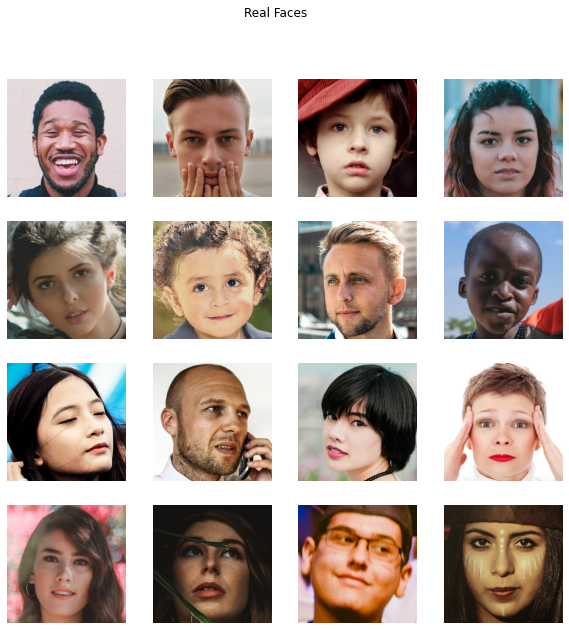

In [8]:
plot_image(train_real_path, 'Real Faces').show()

**Plotting Fake Faces**

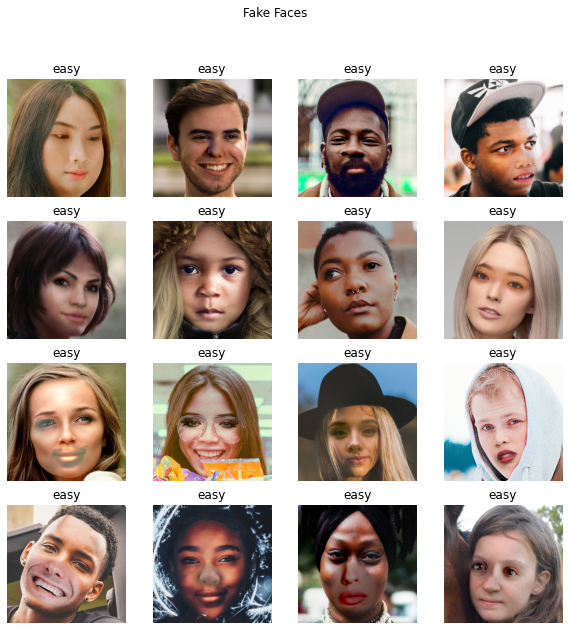

In [9]:
plot_image(train_fake_path, 'Fake Faces').show()

**EDA for Image Classification**

In [10]:
total  = len(os.listdir(train_real_path))+len(os.listdir(train_fake_path))
print(total)

2051


In [11]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [12]:
number_classes = {'Real': len(os.listdir(train_real_path)),
'Fake': len(os.listdir(train_fake_path))}

In [13]:
number_classes

{'Real': 1081, 'Fake': 970}

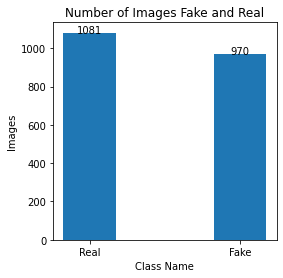

In [14]:
plt.figure(figsize=(4, 4))
plt.bar(number_classes.keys(), number_classes.values(), width = .35);
addlabels(list(number_classes.keys()),  list(number_classes.values()))
plt.title("Number of Images Fake and Real");
plt.xlabel('Class Name');
plt.ylabel('Images');



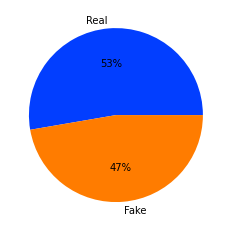

In [15]:
data = [len(os.listdir(train_real_path)), len(os.listdir(train_fake_path))]
labels = ['Real', 'Fake']
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()



In [16]:
from PIL import Image

directories = {'Class_0': train_real_path,
'Class_1': train_fake_path}

def get_dims(file):
  '''Returns dimenstions for an RBG image'''
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

In [17]:
pip install dask[bag]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


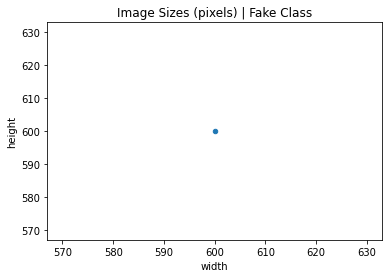

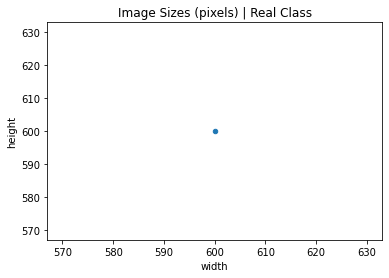

In [18]:
import dask.bag as db

for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims_db = db.from_sequence(filelist).map(get_dims)
  dims = dims_db.compute()
  dim_df = pd.DataFrame(dims, columns=['height', 'width'])
  sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
  sizes.plot.scatter(x='width', y='height');

  
  if (n == 'Class_0'):
    plt.title('Image Sizes (pixels) | Fake Class')
  elif (n=='Class_1'):
    plt.title('Image Sizes (pixels) | Real Class')

## **Preparing Training Set**

In [19]:
data_set_path = '/content/drive/MyDrive/input/real_and_fake_face_detection/real_and_fake_face/'

In [20]:
IMAGE_SIZE = (96, 96)
INPUT_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32 
EPOCHS = 20
learning_rate = 0.001
val_gamma = 2
OPTIMIZER = Adam(learning_rate=learning_rate)


In [21]:
IMAGE_SIZE_VGG = (224, 224)
INPUT_SHAPE_VGG = IMAGE_SIZE_VGG + (3,)

In [22]:
# print(IMG_SHAPE)

In [23]:
data_gen = ImageDataGenerator(rescale=1./255,
                              vertical_flip=False,
                              horizontal_flip=True,
                              validation_split=0.2)

data_gen_test = ImageDataGenerator(rescale=1./255,
                              validation_split=0.2
                             )


In [24]:
training_set = data_gen.flow_from_directory(data_set_path,
                                            class_mode='binary',
                                            target_size=IMAGE_SIZE,
                                            batch_size=BATCH_SIZE,
                                            subset="training",

                                           )

Found 1641 images belonging to 2 classes.


In [25]:
print(training_set)

In [26]:
val = data_gen.flow_from_directory(data_set_path,
                                          class_mode="binary",
                                          target_size=IMAGE_SIZE,
                                          batch_size=BATCH_SIZE,
                                            subset="validation"
                                          )

Found 410 images belonging to 2 classes.


In [27]:
test_data = data_gen_test.flow_from_directory(data_set_path,
                                          class_mode="binary",
                                          target_size=IMAGE_SIZE,
                                          batch_size=BATCH_SIZE,
                                            subset="validation"
                                          )

Found 410 images belonging to 2 classes.


In [28]:
training_set.class_indices

{'training_fake': 0, 'training_real': 1}

In [29]:
from collections import Counter

counter = Counter(training_set.classes)

print(counter.items()) # dict_items([(0, 1648), (1, 3614)])

dict_items([(0, 776), (1, 865)])


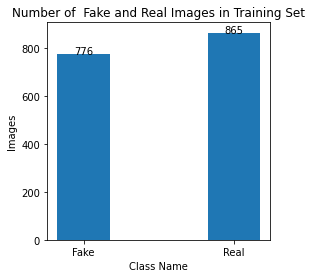

In [30]:
plt.figure(figsize=(4, 4))
plt.bar(['Fake', 'Real'], counter.values(), width = .35);
addlabels(list(counter.keys()),  list(counter.values()))
plt.title("Number of  Fake and Real Images in Training Set");
plt.xlabel('Class Name');
plt.ylabel('Images');


In [31]:

counter = Counter(val.classes)
# counter.rename(columns={'0': 'Fake', '1': 'Real'}, inplace=True)
val_disc = counter.items() # dict_items([(0, 1648), (1, 3614)])
print(val_disc)
counter.columns = ['Fake', 'Real']

dict_items([(0, 194), (1, 216)])


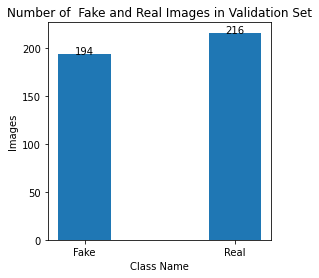

In [32]:
plt.figure(figsize=(4, 4))
plt.bar(['Fake', 'Real'], counter.values(), width = .35);
addlabels(list(counter.keys()),  list(counter.values()))
plt.title("Number of  Fake and Real Images in Validation Set");
plt.xlabel('Class Name');
plt.ylabel('Images');


In [33]:
from collections import Counter

counter = Counter(test_data.classes)

print(counter.items()) # dict_items([(0, 1648), (1, 3614)])

dict_items([(0, 194), (1, 216)])


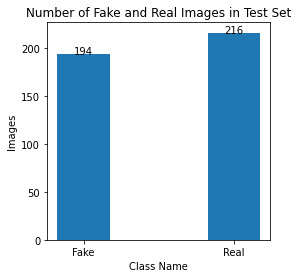

In [34]:
plt.figure(figsize=(4, 4))
plt.bar(['Fake', 'Real'], counter.values(), width = .35);
addlabels(list(counter.keys()),  list(counter.values()))
plt.title("Number of Fake and Real Images in Test Set");
plt.xlabel('Class Name');
plt.ylabel('Images');

**Callbacks**

In [35]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)


**Plots for Accuracy**

In [36]:
def plot_accuracy_loss(gHist):
    epochs = 20
    train_loss = gHist.history['loss']
    val_loss = gHist.history['val_loss']
    train_acc = gHist.history['accuracy']
    val_acc = gHist.history['val_accuracy']
    xc = range(epochs)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train loss vs val loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train acc vs val acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])


In [37]:
def plot_accuracy_loss_fine_tune(gHist):
    epochs = 30
    train_loss = gHist.history['loss']
    val_loss = gHist.history['val_loss']
    train_acc = gHist.history['accuracy']
    val_acc = gHist.history['val_accuracy']
    xc = range(epochs)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train loss vs val loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train acc vs val acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

In [38]:
def plot_fine_tune_model(gHist,history_fine):
    
    loss = gHist.history['loss']
    val_loss = gHist.history['val_loss']
    acc = gHist.history['accuracy']
    val_acc = gHist.history['val_accuracy']

    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']


    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 3])
    plt.plot([EPOCHS-1,EPOCHS-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 3.0])
    plt.plot([EPOCHS-1,EPOCHS-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

In [39]:
def show_cofusion_matrix(selected_model):

    #Predict classes

    test_steps_per_epoch = np.math.ceil(val.samples / val.batch_size)

    predictions = selected_model.predict_generator(val, steps=test_steps_per_epoch)
    # Get most likely class
    predicted_classes = np.argmax(predictions, axis=1)

    #Get ground-truth classes and class-labels

    true_classes = val.classes
    # class_labels = list(val.class_indices.keys()) 
    class_labels = ['fake', 'real'] 

    print(' ======= Confusion Matrix ====== \n')
    cm = confusion_matrix(true_classes, predicted_classes)
    print(cm)

    # Use scikit-learn to get statistics
    print(' ======= Classification Report  ======= \n')
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report) 

    print(' ======= Confusion Matrix Display  ======= \n')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
    disp.plot()
    plt.show()





In [40]:
def print_model(p_model):
  tf.keras.utils.plot_model(p_model, show_shapes=True, show_layer_names=True)

In [41]:
# def show_roc(selected_model):
  #Predict classes

    # test_steps_per_epoch = np.math.ceil(val.samples / val.batch_size)

    # predictions = selected_model.predict_generator(val, steps=test_steps_per_epoch)
    # # Get most likely class
    # predicted_classes = np.argmax(predictions, axis=1)

    # #Get ground-truth classes and class-labels

    # true_classes = val.classes
    # # class_labels = list(val.class_indices.keys()) 
    # class_labels = ['fake', 'real'] 
    # # calculate roc curve
    # fpr, tpr, thresholds = roc_curve(true_classes, predicted_classes)

    # # ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    # # lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # # plot the roc curve for the model
    # # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # plt.plot(fpr, tpr, marker='.', label='Model')
    # # axis labels
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # # show the legend
    # plt.legend()
    # # show the plot
    # plt.show()

In [42]:
# LOSS ="sparse_categorical_crossentropy"
LOSS = SparseCategoricalFocalLoss(gamma=val_gamma)

# **Building Model Architecture**

## **Model 1: MobileNetV3Small**

In [ ]:
mobilenet = MobileNetV3Small(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )
#Stack the feature extractor, adn these  layers using tf.keras.Sequential model
model1 = tf.keras.models.Sequential([mobilenet,
                                    GlobalAveragePooling2D(),# To generate predictions from the block of features, using tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single element vector per image
                                    Dense(512, activation='relu'),#Applying tf.keras.layers.Dense layer to convert these features into a single prediction per image.
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
# Setting the top layer as non trainable
model1.layers[0].trainable = False
model1.compile(optimizer=OPTIMIZER,
              loss= LOSS,
              metrics=['accuracy'])


In [ ]:
model1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_16  (None, 576)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_50 (Dense)            (None, 512)               295424    
                                                                 
 batch_normalization_16 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                     

In [ ]:
hist1 = model1.fit(training_set, epochs=EPOCHS,validation_data=val,callbacks=[lr_callbacks])

Epoch 1/20
52/52 [==============================] - 38s 664ms/step - loss: 0.2263 - accuracy: 0.5320 - val_loss: 0.2047 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - 33s 637ms/step - loss: 0.1978 - accuracy: 0.5600 - val_loss: 0.1998 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - 33s 635ms/step - loss: 0.1803 - accuracy: 0.5954 - val_loss: 0.1822 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 36s 691ms/step - loss: 0.1695 - accuracy: 0.6027 - val_loss: 0.1798 - val_accuracy: 0.4732 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 33s 640ms/step - loss: 0.1658 - accuracy: 0.6216 - val_loss: 0.1750 - val_accuracy: 0.4780 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 33s 640ms/step - loss: 0.1625 - accuracy: 0.6380 - val_loss: 0.1744 - val_accuracy: 0.4854 - lr: 1.0000e-04
Epoch 7/20
52/52 [==============================] - 

In [ ]:
model1.save("model1.h5")

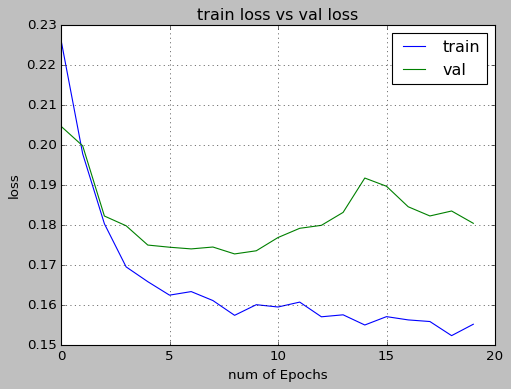

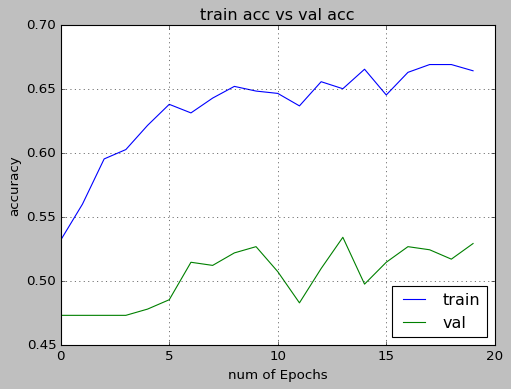

In [ ]:
plot_accuracy_loss(hist1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


 ======= Confusion Matrix ====== 

[[ 53 141]
 [ 77 139]]
 ======= Classification Report  ======= 

              precision    recall  f1-score   support

        fake       0.41      0.27      0.33       194
        real       0.50      0.64      0.56       216

    accuracy                           0.47       410
   macro avg       0.45      0.46      0.44       410
weighted avg       0.45      0.47      0.45       410

 ======= Confusion Matrix Display  ======= 



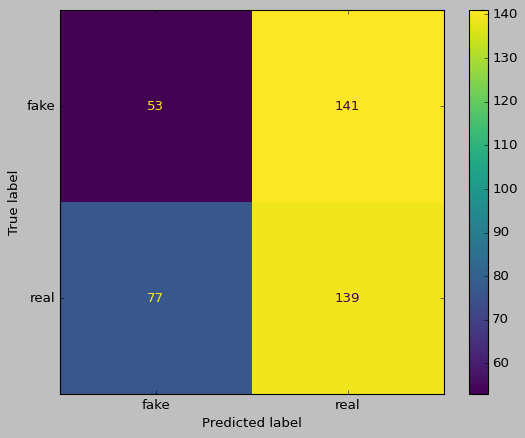

In [ ]:
show_cofusion_matrix(model1)

In [ ]:
loss, accuracy = model1.evaluate(val)
print('Test accuracy :', accuracy)
print('Test loss : ',loss)

13/13 [==============================] - 7s 519ms/step - loss: 0.1827 - accuracy: 0.5293
Test accuracy : 0.5292682647705078
Test loss :  0.18265856802463531


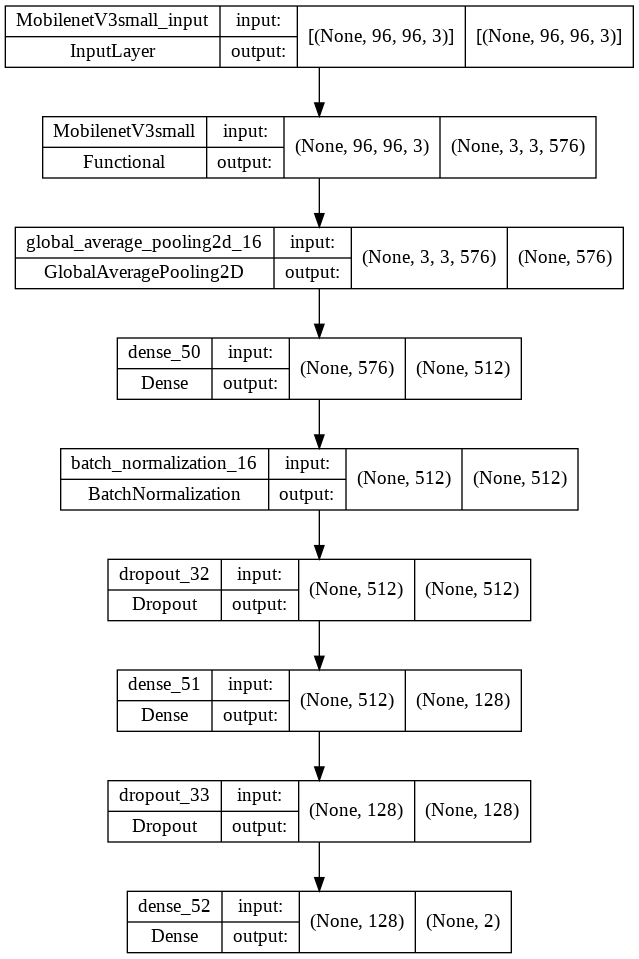

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

## **Model 2: MobileNetV3Large** 

In [ ]:
mobilenet_large = MobileNetV3Large(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )
model2 = tf.keras.models.Sequential([mobilenet_large,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
model2.layers[0].trainable = False
model2.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])


In [ ]:
model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 3, 3, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_17  (None, 960)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_53 (Dense)            (None, 512)               492032    
                                                                 
 batch_normalization_17 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                     

In [ ]:
hist2 = model2.fit(training_set, epochs=EPOCHS,validation_data=val,callbacks=[lr_callbacks])

Epoch 1/20
52/52 [==============================] - 44s 742ms/step - loss: 0.4076 - accuracy: 0.5180 - val_loss: 0.1967 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - 37s 712ms/step - loss: 0.1960 - accuracy: 0.5302 - val_loss: 0.2176 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - 40s 775ms/step - loss: 0.1770 - accuracy: 0.5667 - val_loss: 0.1807 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 37s 710ms/step - loss: 0.1715 - accuracy: 0.5765 - val_loss: 0.1743 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 42s 813ms/step - loss: 0.1682 - accuracy: 0.5923 - val_loss: 0.1730 - val_accuracy: 0.5220 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 37s 714ms/step - loss: 0.1681 - accuracy: 0.5740 - val_loss: 0.1726 - val_accuracy: 0.5073 - lr: 1.0000e-04
Epoch 7/20
52/52 [==============================] - 

In [ ]:
model2.save("model2.h5")

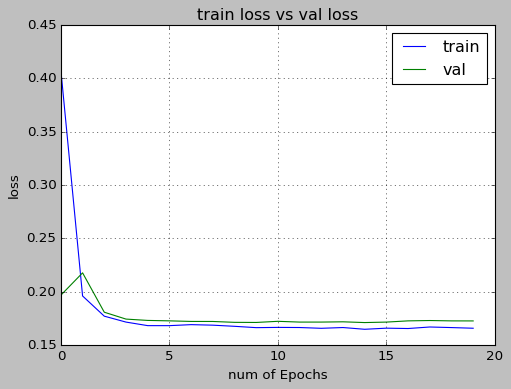

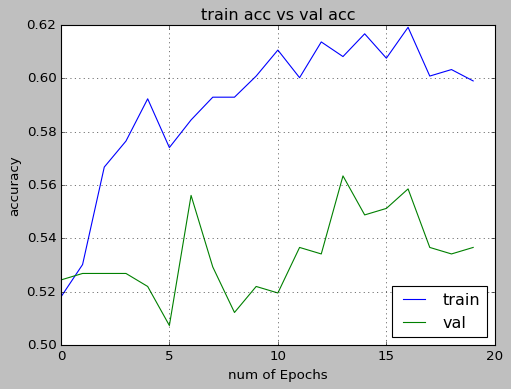

In [ ]:
plot_accuracy_loss(hist2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


 ======= Confusion Matrix ====== 

[[ 55 139]
 [ 60 156]]
 ======= Classification Report  ======= 

              precision    recall  f1-score   support

        fake       0.48      0.28      0.36       194
        real       0.53      0.72      0.61       216

    accuracy                           0.51       410
   macro avg       0.50      0.50      0.48       410
weighted avg       0.50      0.51      0.49       410

 ======= Confusion Matrix Display  ======= 



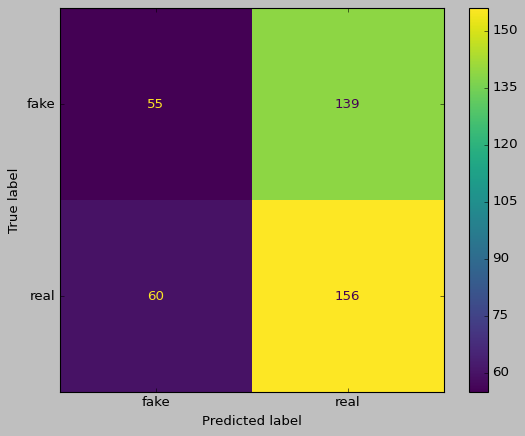

In [ ]:
show_cofusion_matrix(model2)

In [ ]:
# show_roc(model2)

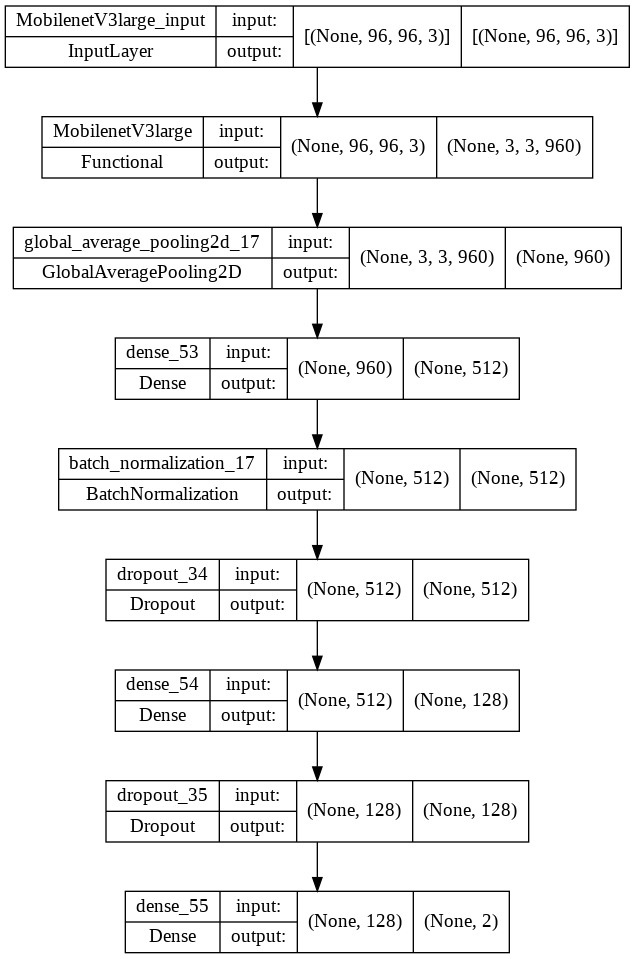

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

## **Model 3: MobileNetV2** 

In [ ]:
mnetV2 = MobileNetV2(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )
model3 = tf.keras.models.Sequential([mnetV2,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
model3.layers[0].trainable = False
model3.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_18  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_56 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_18 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                     

In [ ]:
hist3 = model3.fit(training_set, epochs=EPOCHS,validation_data=val,callbacks=[lr_callbacks])

Epoch 1/20
52/52 [==============================] - 40s 772ms/step - loss: 0.2260 - accuracy: 0.6185 - val_loss: 0.3671 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - 39s 742ms/step - loss: 0.1528 - accuracy: 0.6831 - val_loss: 0.2480 - val_accuracy: 0.5829 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - 38s 727ms/step - loss: 0.1389 - accuracy: 0.7325 - val_loss: 0.2253 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 40s 772ms/step - loss: 0.1246 - accuracy: 0.7623 - val_loss: 0.2221 - val_accuracy: 0.5195 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 39s 732ms/step - loss: 0.1207 - accuracy: 0.7824 - val_loss: 0.2256 - val_accuracy: 0.4976 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 38s 730ms/step - loss: 0.1214 - accuracy: 0.7666 - val_loss: 0.2277 - val_accuracy: 0.5195 - lr: 1.0000e-04
Epoch 7/20
52/52 [==============================] - 

In [ ]:
model3.save("model3.h5")

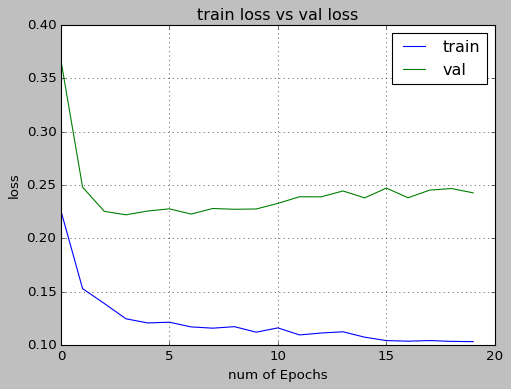

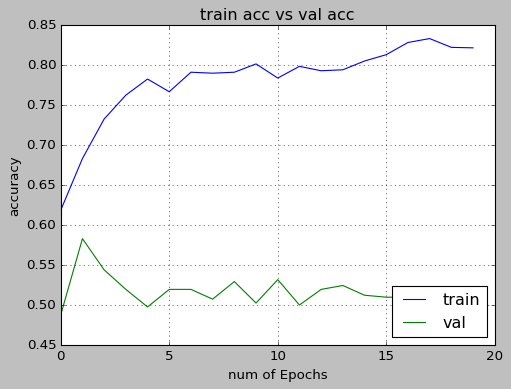

In [ ]:
plot_accuracy_loss(hist3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


 ======= Confusion Matrix ====== 

[[ 65 129]
 [ 80 136]]
 ======= Classification Report  ======= 

              precision    recall  f1-score   support

        fake       0.45      0.34      0.38       194
        real       0.51      0.63      0.57       216

    accuracy                           0.49       410
   macro avg       0.48      0.48      0.47       410
weighted avg       0.48      0.49      0.48       410

 ======= Confusion Matrix Display  ======= 



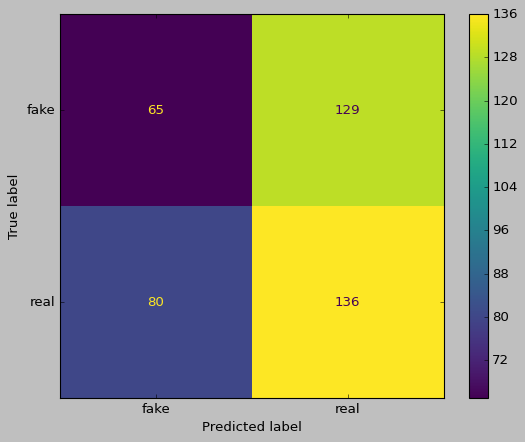

In [ ]:
show_cofusion_matrix(model3)

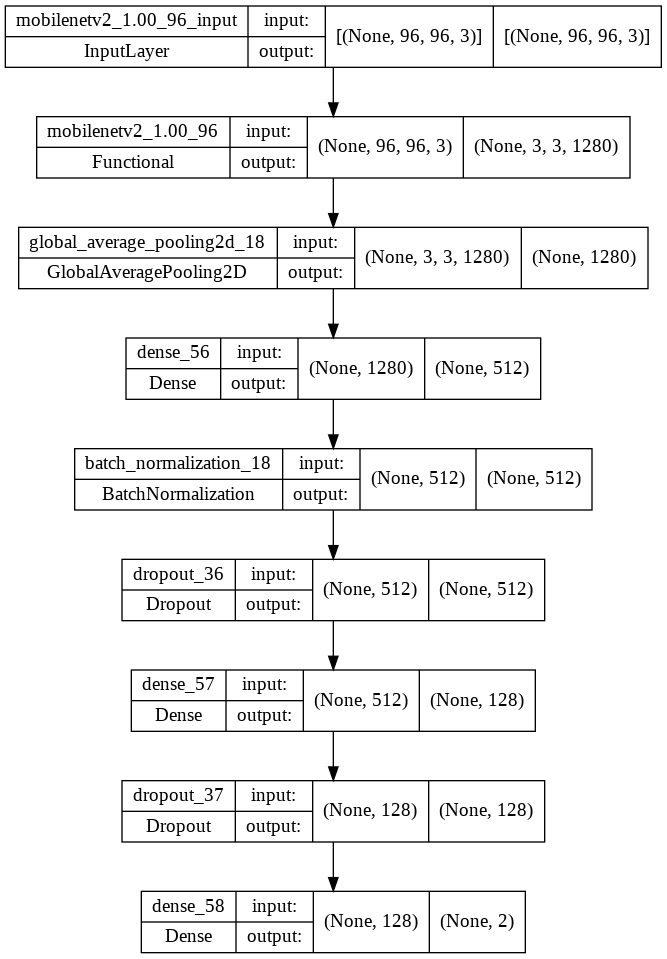

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True)

## **Model 4: VGG16 Model**

In [43]:
training_set_vg = data_gen.flow_from_directory(data_set_path,
                                            class_mode='binary',
                                            shuffle=True,
                                            target_size=IMAGE_SIZE_VGG,
                                            batch_size=BATCH_SIZE,
                                           )

val_vg = data_gen.flow_from_directory(data_set_path,
                                          class_mode="binary",
                                          target_size=IMAGE_SIZE_VGG,
                                          batch_size=BATCH_SIZE,
                                          subset="validation"
                                          )

Found 2051 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [44]:
#IMAGE_SIZE_VGG
INPUT_SHAPE_VGG

(224, 224, 3)

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=INPUT_SHAPE_VGG,
                        include_top=False,
                        weights='imagenet')
vgg16_model.output[-1]



58889256/58889256 [==============================] - 1s 0us/step


<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:
model4 = tf.keras.models.Sequential([vgg16_model,
                                    Flatten(),
                                    Dense(2, activation='softmax')
                                   ])
model4.layers[0].trainable = False
model4.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy']
             )

In [ ]:
model4.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_60 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
hist4 = model4.fit(x=training_set_vg, epochs=EPOCHS,validation_data=val_vg,callbacks=[lr_callbacks,early_stop])

Epoch 1/20
65/65 [==============================] - 1286s 20s/step - loss: 7.5070 - accuracy: 0.5271 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - 1272s 20s/step - loss: 7.6229 - accuracy: 0.5271 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - 1268s 20s/step - loss: 7.6229 - accuracy: 0.5271 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - 1267s 20s/step - loss: 7.6229 - accuracy: 0.5271 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 5/20
65/65 [==============================] - 1265s 20s/step - loss: 7.6229 - accuracy: 0.5271 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 6/20
65/65 [==============================] - 1266s 20s/step - loss: 7.6229 - accuracy: 0.5271 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 7/20
65/65 [==============================] - 

In [ ]:
model4.save("model4.h5")

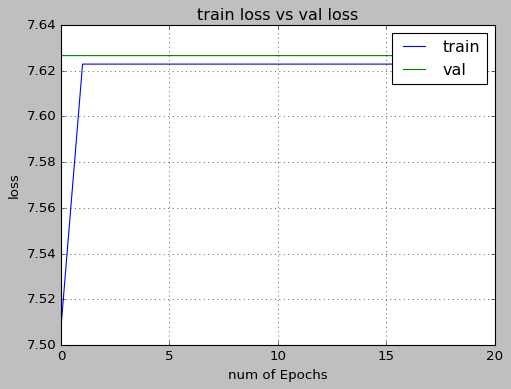

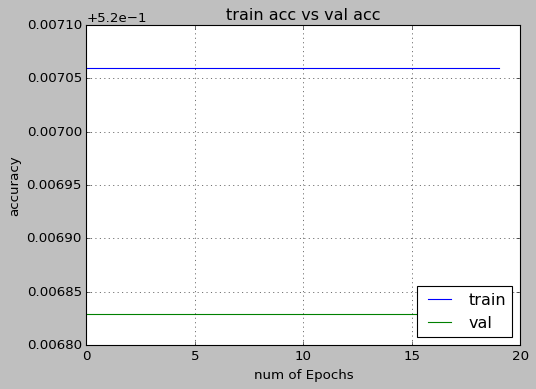

In [ ]:
plot_accuracy_loss(hist4)

In [ ]:
#show_cofusion_matrix(model4)

NameError: ignored

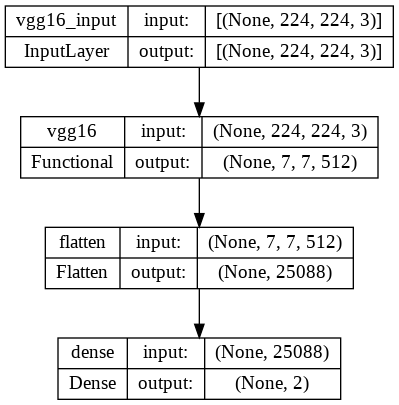

In [ ]:
tf.keras.utils.plot_model(model4, show_shapes=True, show_layer_names=True)

# **Fine Tuning**

In [45]:
learning_rate = 0.0001
OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10)


### **Model 5: MobileNetV3Small**

In [46]:
base_model = MobileNetV3Small(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )

4349952/4334752 [==============================] - 0s 0us/step


In [47]:
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 576)


In [48]:
base_model.trainable = False

In [49]:
# base_model.summary()

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 576)


In [51]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [52]:
base_model.trainable = True

In [53]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  229


In [54]:

model5 = tf.keras.models.Sequential([base_model,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
model5.compile(optimizer = OPTIMIZER,
              loss= LOSS,
              metrics=['accuracy'])

In [55]:
len(model5.trainable_variables)

81

In [56]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 512)               295424    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [57]:
fine_tune_epochs = 10

hist5 = model5.fit(training_set, epochs=EPOCHS+fine_tune_epochs,validation_data=val,callbacks=[lr_callbacks])

Epoch 1/30
52/52 [==============================] - 43s 675ms/step - loss: 0.6103 - accuracy: 0.5265 - val_loss: 0.1900 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 2/30
52/52 [==============================] - 35s 677ms/step - loss: 0.3932 - accuracy: 0.5308 - val_loss: 0.1869 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 3/30
52/52 [==============================] - 33s 633ms/step - loss: 0.2811 - accuracy: 0.5320 - val_loss: 0.2023 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 4/30
52/52 [==============================] - 38s 729ms/step - loss: 0.2460 - accuracy: 0.5424 - val_loss: 0.2141 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 5/30
52/52 [==============================] - 35s 667ms/step - loss: 0.2379 - accuracy: 0.5783 - val_loss: 0.1793 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 6/30
52/52 [==============================] - 33s 636ms/step - loss: 0.2058 - accuracy: 0.5728 - val_loss: 0.1755 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 7/30
52/52 [==============================] - 

In [58]:
model5.save("model5.h5")

In [59]:
# plot_fine_tune_model(hist1,hist5)
# plot_accuracy_loss_fine_tune(hist5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


 ======= Confusion Matrix ====== 

[[191   3]
 [205  11]]
 ======= Classification Report  ======= 

              precision    recall  f1-score   support

        fake       0.48      0.98      0.65       194
        real       0.79      0.05      0.10       216

    accuracy                           0.49       410
   macro avg       0.63      0.52      0.37       410
weighted avg       0.64      0.49      0.36       410

 ======= Confusion Matrix Display  ======= 



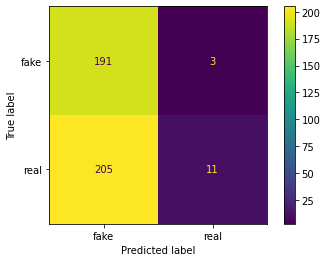

In [60]:
show_cofusion_matrix(model5)

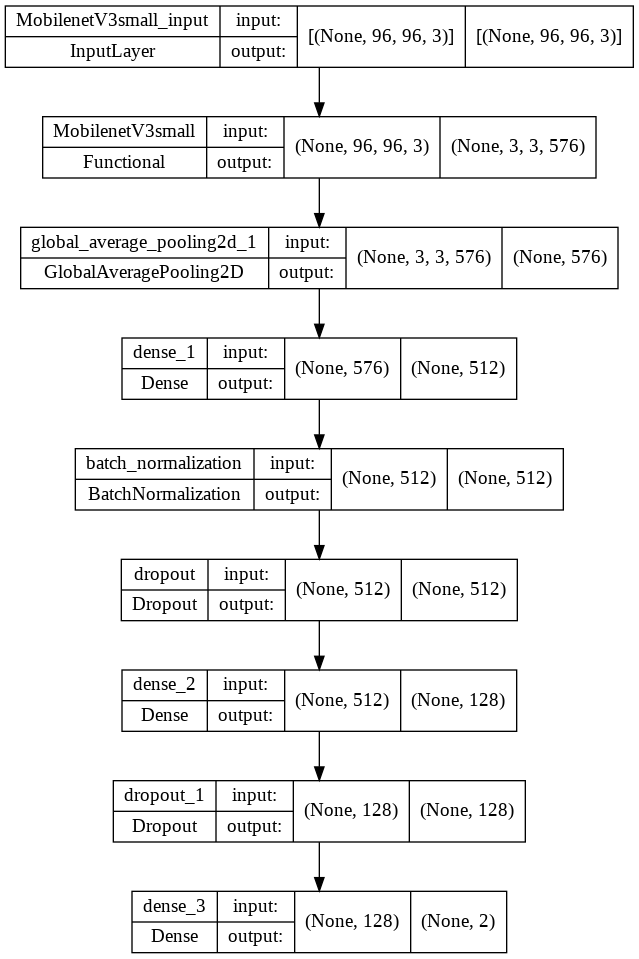

In [61]:
tf.keras.utils.plot_model(model5, show_shapes=True, show_layer_names=True)

In [62]:
loss, accuracy = model5.evaluate(val)
print('Test accuracy :', accuracy)

13/13 [==============================] - 7s 521ms/step - loss: 1.9424 - accuracy: 0.4707
Test accuracy : 0.4707317054271698


### **Model 6: MobileNetV3Large** 

In [63]:
base_model = MobileNetV3Large(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )

12697600/12683000 [==============================] - 0s 0us/step


In [64]:
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 960)


In [65]:
base_model.trainable = False

In [66]:
# base_model.summary()

In [67]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [68]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [69]:
base_model.trainable = True

In [70]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [71]:

model6 = tf.keras.models.Sequential([base_model,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
model6.compile(optimizer = OPTIMIZER,
              loss= LOSS,
              metrics=['accuracy'])

In [72]:
len(model6.trainable_variables)

100

In [73]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 3, 3, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 512)               492032    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

In [74]:
fine_tune_epochs = 10

hist6 = model6.fit(training_set, epochs=EPOCHS+fine_tune_epochs,validation_data=val,callbacks=[lr_callbacks])

Epoch 1/30
52/52 [==============================] - 55s 886ms/step - loss: 0.6551 - accuracy: 0.5088 - val_loss: 0.1773 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 2/30
52/52 [==============================] - 46s 887ms/step - loss: 0.4246 - accuracy: 0.5539 - val_loss: 0.2341 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 3/30
52/52 [==============================] - 49s 931ms/step - loss: 0.3152 - accuracy: 0.5417 - val_loss: 0.1743 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 4/30
52/52 [==============================] - 44s 839ms/step - loss: 0.2594 - accuracy: 0.5399 - val_loss: 0.1737 - val_accuracy: 0.5171 - lr: 1.0000e-04
Epoch 5/30
52/52 [==============================] - 44s 839ms/step - loss: 0.2215 - accuracy: 0.5558 - val_loss: 0.1813 - val_accuracy: 0.5220 - lr: 1.0000e-04
Epoch 6/30
52/52 [==============================] - 45s 867ms/step - loss: 0.2142 - accuracy: 0.5783 - val_loss: 0.1888 - val_accuracy: 0.5244 - lr: 1.0000e-04
Epoch 7/30
52/52 [==============================] - 

In [75]:
#model6.save("model6.h5")

In [76]:
# plot_fine_tune_model(hist2,hist6)
# plot_accuracy_loss_fine_tune(hist6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


 ======= Confusion Matrix ====== 

[[194   0]
 [216   0]]
 ======= Classification Report  ======= 

              precision    recall  f1-score   support

        fake       0.47      1.00      0.64       194
        real       0.00      0.00      0.00       216

    accuracy                           0.47       410
   macro avg       0.24      0.50      0.32       410
weighted avg       0.22      0.47      0.30       410

 ======= Confusion Matrix Display  ======= 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


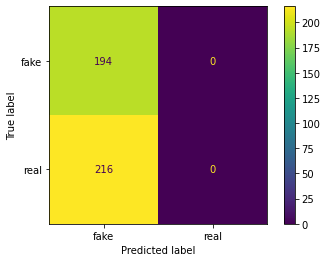

In [77]:
show_cofusion_matrix(model6)

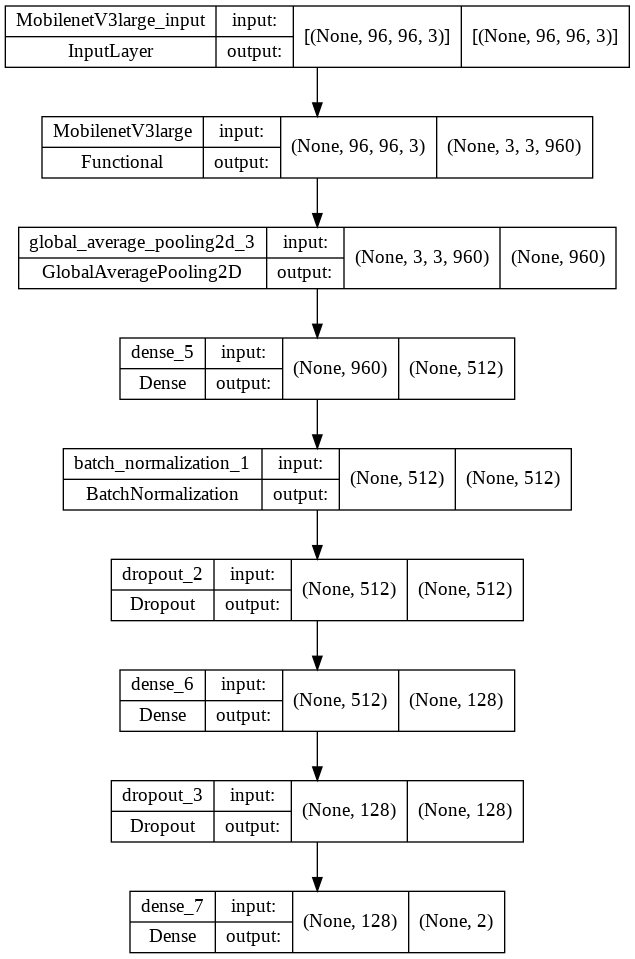

In [78]:
tf.keras.utils.plot_model(model6, show_shapes=True, show_layer_names=True)

In [79]:
loss, accuracy = model6.evaluate(val)
print('Test accuracy :', accuracy)

13/13 [==============================] - 8s 546ms/step - loss: 0.5050 - accuracy: 0.4732
Test accuracy : 0.4731707274913788


### **Model 7: MobileNetV2** 

In [80]:
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )

9420800/9406464 [==============================] - 0s 0us/step


In [81]:
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


In [82]:
base_model.trainable = False

In [83]:
# base_model.summary()

In [84]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [85]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [86]:
base_model.trainable = True

In [87]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [88]:

model7 = tf.keras.models.Sequential([base_model,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
model7.compile(optimizer = OPTIMIZER,
              loss= LOSS,
              metrics=['accuracy'])

In [89]:
len(model7.trainable_variables)

62

In [90]:
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [91]:
fine_tune_epochs = 10

hist7 = model7.fit(training_set, epochs=EPOCHS+fine_tune_epochs,validation_data=val,callbacks=[lr_callbacks])

Epoch 1/30
52/52 [==============================] - 50s 843ms/step - loss: 0.5947 - accuracy: 0.5734 - val_loss: 3.1451 - val_accuracy: 0.4756 - lr: 0.0010
Epoch 2/30
52/52 [==============================] - 46s 886ms/step - loss: 0.3677 - accuracy: 0.6069 - val_loss: 3.7018 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 3/30
52/52 [==============================] - 42s 809ms/step - loss: 0.3252 - accuracy: 0.6149 - val_loss: 1.4243 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 4/30
52/52 [==============================] - 42s 812ms/step - loss: 0.2220 - accuracy: 0.6600 - val_loss: 0.2585 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 5/30
52/52 [==============================] - 46s 885ms/step - loss: 0.2169 - accuracy: 0.6825 - val_loss: 1.3320 - val_accuracy: 0.4732 - lr: 1.0000e-04
Epoch 6/30
52/52 [==============================] - 42s 811ms/step - loss: 0.1700 - accuracy: 0.7087 - val_loss: 1.3510 - val_accuracy: 0.4732 - lr: 1.0000e-04
Epoch 7/30
52/52 [==============================] - 

In [93]:
# model7.save("model7.h5")

In [94]:
# plot_fine_tune_model(hist3,hist7)
# plot_accuracy_loss_fine_tune(hist7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


 ======= Confusion Matrix ====== 

[[ 38 156]
 [ 55 161]]
 ======= Classification Report  ======= 

              precision    recall  f1-score   support

        fake       0.41      0.20      0.26       194
        real       0.51      0.75      0.60       216

    accuracy                           0.49       410
   macro avg       0.46      0.47      0.43       410
weighted avg       0.46      0.49      0.44       410

 ======= Confusion Matrix Display  ======= 



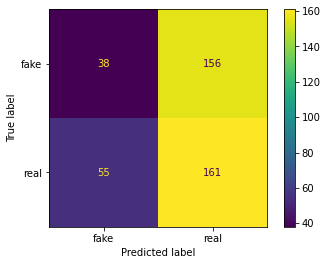

In [95]:
show_cofusion_matrix(model7)

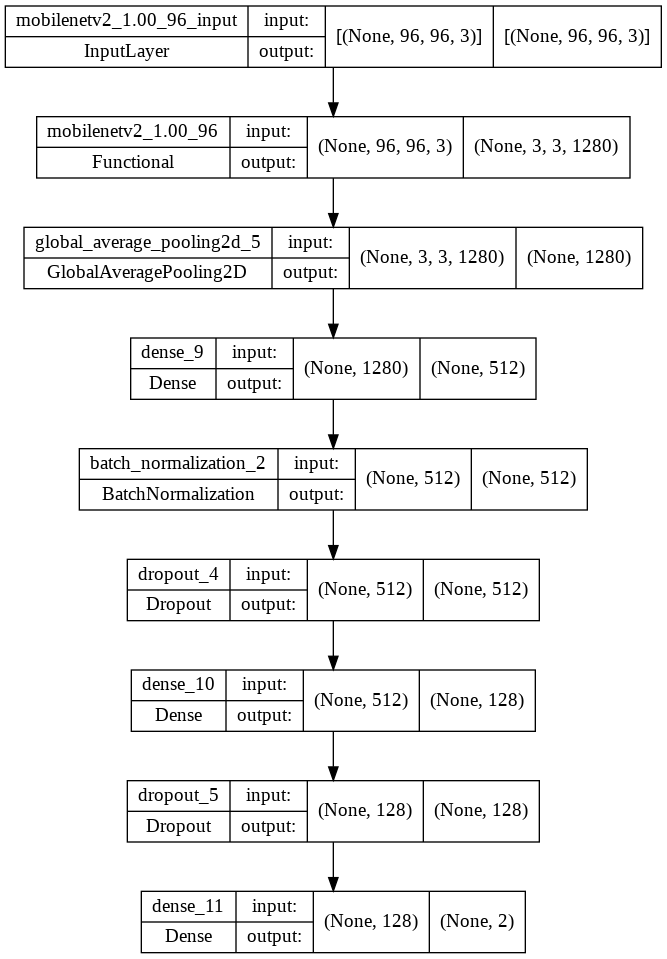

In [96]:
tf.keras.utils.plot_model(model7, show_shapes=True, show_layer_names=True)

In [97]:
loss, accuracy = model7.evaluate(val)
print('Test accuracy :', accuracy)

13/13 [==============================] - 7s 539ms/step - loss: 1.2489 - accuracy: 0.5537
Test accuracy : 0.5536585450172424


### **Model 8: VGG16 Model**

In [98]:
base_model =  tf.keras.applications.vgg16.VGG16(input_shape=INPUT_SHAPE_VGG,
                        include_top=False,
                        weights='imagenet')
base_model.output[-1]

58900480/58889256 [==============================] - 0s 0us/step


<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [99]:
image_batch, label_batch = next(iter(training_set_vg))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [100]:
base_model.trainable = False

In [101]:
# base_model.summary()

In [102]:
base_model.trainable = True

In [103]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [104]:

model8 = tf.keras.models.Sequential([base_model,
                                    Flatten(),
                                    Dense(2, activation='softmax')
                                   ])
model8.layers[0].trainable = False
model8.compile(optimizer=OPTIMIZER,
              loss= LOSS,
              metrics=['accuracy']
             )


In [105]:
len(model8.trainable_variables)

2

In [106]:
model8.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [107]:
# EarlyStopping

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
fine_tune_epochs = 10

hist8 = model8.fit(training_set_vg, epochs=EPOCHS+fine_tune_epochs,validation_data=val_vg,callbacks=[lr_callbacks,early_stop])

Epoch 1/30
65/65 [==============================] - 1143s 18s/step - loss: 7.5091 - accuracy: 0.5275 - val_loss: 7.6266 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - ETA: 0s - loss: 7.6229 - accuracy: 0.5271 

In [ ]:
# model8.save("model8.h5")

In [ ]:
# plot_fine_tune_model(hist4,hist8)
#  plot_accuracy_loss_fine_tune(hist8)

In [ ]:
# show_cofusion_matrix(model8)

In [ ]:
tf.keras.utils.plot_model(model8, show_shapes=True, show_layer_names=True)

In [ ]:
loss, accuracy = model8.evaluate(val_vg)
print('Test accuracy :', accuracy)

# **Hyper Parameter Tuning**

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import keras_tuner
from tensorflow import keras

### **Model 9: MobileNetV3Small**

In [ ]:
def build_model(hp):
    mnetV3_small_hyper = MobileNetV3Small(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )
    model9 = keras.Sequential()
    model9.add(mnetV3_small_hyper)
    model9.add(GlobalAveragePooling2D())


    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 2 - 4
    # Number of Units: 32 - 512 with stepsize of 32
    # Layer ======= 1 =========
    model9.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(1), min_value=100, max_value=612, step=32),
                activation="relu")
            )
    model9.add(BatchNormalization())
         # Tune dropout layer with values from 0 - 0.3.
    model9.add(keras.layers.Dropout(hp.Float("dropout_" + str(1), 0, 0.4, step=0.1)))
    
    # Layer ======= 2 =========
    model9.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(2), min_value=100, max_value=612, step=32),
                activation="relu")
            )
    
         # Tune dropout layer with values from 0 - 0.3.
    model9.add(keras.layers.Dropout(hp.Float("dropout_" + str(2), 0, 0.4, step=0.1)))

    for i in range(3, hp.Int("num_layers", 3, 5)):
        model9.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=50, max_value=612, step=32),
                activation="relu")
            )
         # Tune dropout layer with values from 0 - 0.3.
        model9.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.4, step=0.1)))
    
    # Add output layer.
    model9.add(keras.layers.Dense(units=2, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1,1e-2, 1e-3, 1e-4])
    model9.layers[0].trainable = False

    hp_gamma=hp.Int("units_gamma" , min_value=2, max_value=10, step=2)
    
    model9.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss= LOSS,
                  metrics=["accuracy"])


    # hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

    # if hp_optimizer == 'Adam':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])
    # elif hp_optimizer == 'SGD':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])

    return model9


build_model(keras_tuner.HyperParameters())

In [ ]:
tuner_mlp = keras_tuner.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     max_trials = 20,
                     directory='my_dir',
                     project_name='intro_to_kt')


tuner_mlp.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner_mlp.search(training_set, epochs=EPOCHS+fine_tune_epochs,validation_data=val,callbacks=[stop_early] )

In [ ]:
best_hps = tuner_mlp.get_best_hyperparameters()[0]

#grab the best hyperparameters
print("[INFO] optimal number of  layer: {}".format(
	best_hps.get("num_layers")))

# print("[INFO] optimal number of filters in dense_1 layer: {}".format(
# 	best_hps.get("dense_1")))
print("[INFO] optimal number of filters in dropout_1 layer: {}".format(
	best_hps.get("dropout_1")))
# print("[INFO] optimal number of units in dense layer: {}".format(
# 	best_hps.get("unit_2")))
print("[INFO] optimal number of filters in dropout_2 layer: {}".format(
	best_hps.get("dropout_2")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))
print("[INFO] optimal number of filters in gamma layer: {}".format(
	best_hps.get("units_gamma")))
#best_hps

In [ ]:
print(best_hps)

In [ ]:
model9 = build_model(best_hps)

In [ ]:
model9.summary()

In [ ]:
hist9 = model9.fit(training_set, epochs=EPOCHS,validation_data=val)

In [ ]:
# model9.save("model9.h5")

In [ ]:
plot_accuracy_loss(hist9)

In [ ]:
show_cofusion_matrix(model9)

In [ ]:
tf.keras.utils.plot_model(model9, show_shapes=True, show_layer_names=True)

### **Model 10: MobileNetV3Large**

In [ ]:
def build_model_large(hp):
    mnetV3_large_hyper = MobileNetV3Large(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )
    model10 = keras.Sequential()
    model10.add(mnetV3_large_hyper)
    model10.add(GlobalAveragePooling2D())


    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 2 - 4
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 1, 4)):
        model10.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=100, max_value=612, step=32),
                activation="relu")
            )
        model10.add(BatchNormalization())
        # Tune dropout layer with values from 0 - 0.3.
        model10.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.4, step=0.1)))
    
    # Add output layer.
    model10.add(keras.layers.Dense(units=2, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1,1e-2, 1e-3, 1e-4])
    model10.layers[0].trainable = False

    hp_gamma=hp.Int("units_gamma" , min_value=2, max_value=10, step=2)
    
    model10.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss= LOSS,
                  metrics=["accuracy"])
  

    # hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

    # if hp_optimizer == 'Adam':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])
    # elif hp_optimizer == 'SGD':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])

    return model10


build_model_large(keras_tuner.HyperParameters())

In [ ]:
tuner_mlp = keras_tuner.Hyperband(build_model_large,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     max_trials = 20,
                     directory='my_dir_large',
                     project_name='intro_to_kt_large')


tuner_mlp.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner_mlp.search(training_set, epochs=EPOCHS+fine_tune_epochs,validation_data=val,callbacks=[stop_early] )

In [ ]:
best_hps = tuner_mlp.get_best_hyperparameters()[0]

#grab the best hyperparameters
print("[INFO] optimal number of  layer: {}".format(
	best_hps.get("num_layers")))

# print("[INFO] optimal number of filters in dense_1 layer: {}".format(
# 	best_hps.get("dense_1")))
print("[INFO] optimal number of filters in dropout_1 layer: {}".format(
	best_hps.get("dropout_1")))
# print("[INFO] optimal number of units in dense layer: {}".format(
# 	best_hps.get("unit_2")))
print("[INFO] optimal number of filters in dropout_2 layer: {}".format(
	best_hps.get("dropout_2")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))
print("[INFO] optimal number of filters in gamma layer: {}".format(
	best_hps.get("units_gamma")))
#best_hps

In [ ]:
print(best_hps)

In [ ]:
model10 = build_model_large(best_hps)

In [ ]:
model10.summary()

In [ ]:
hist10 = model10.fit(training_set, epochs=EPOCHS,validation_data=val)

In [ ]:
# model10.save("hist10.h5")

In [ ]:
plot_accuracy_loss(hist10)

In [ ]:
show_cofusion_matrix(model10)

In [ ]:
tf.keras.utils.plot_model(model10, show_shapes=True, show_layer_names=True)

### **Model 11: MobileNetV2**

In [ ]:
def build_model_v2(hp):
    mnetV2_hyper = MobileNetV2(input_shape=INPUT_SHAPE,
                        include_top=False,
                        weights='imagenet'
                       )
    model11 = keras.Sequential()
    model11.add(mnetV2_hyper)
    model11.add(GlobalAveragePooling2D())


    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 2 - 4
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 1, 4)):
        model11.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=100, max_value=612, step=32),
                activation="relu")
            )
        model11.add(BatchNormalization())
        # Tune dropout layer with values from 0 - 0.3.
        model11.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.4, step=0.1)))
    
    # Add output layer.
    model11.add(keras.layers.Dense(units=2, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1,1e-2, 1e-3, 1e-4])
    model11.layers[0].trainable = False

    hp_gamma=hp.Int("units_gamma" , min_value=2, max_value=10, step=2)
    
    model11.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss= LOSS,
                  metrics=["accuracy"])
  

    # hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

    # if hp_optimizer == 'Adam':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])
    # elif hp_optimizer == 'SGD':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])

    return model11


build_model_v2(keras_tuner.HyperParameters())

In [ ]:
tuner_mlp = keras_tuner.Hyperband(build_model_v2,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     max_trials = 20,
                     directory='my_dir_v2',
                     project_name='intro_to_kt_v2')


tuner_mlp.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner_mlp.search(training_set, epochs=EPOCHS,validation_data=val,callbacks=[stop_early] )

In [ ]:
best_hps = tuner_mlp.get_best_hyperparameters()[0]

#grab the best hyperparameters
print("[INFO] optimal number of  layer: {}".format(
	best_hps.get("num_layers")))

# print("[INFO] optimal number of filters in dense_1 layer: {}".format(
# 	best_hps.get("dense_1")))
print("[INFO] optimal number of filters in dropout_1 layer: {}".format(
	best_hps.get("dropout_1")))
# print("[INFO] optimal number of units in dense layer: {}".format(
# 	best_hps.get("unit_2")))
print("[INFO] optimal number of filters in dropout_2 layer: {}".format(
	best_hps.get("dropout_2")))
print("[INFO] optimal learning rate: {:.4f}".format(
	best_hps.get("learning_rate")))
print("[INFO] optimal number of filters in gamma layer: {}".format(
	best_hps.get("units_gamma")))
#best_hps

In [ ]:
print(best_hps)

In [ ]:
model11 = build_model_v2(best_hps)

In [ ]:
model11.summary()

In [ ]:
hist11 = model11.fit(training_set, epochs=EPOCHS+fine_tune_epochs,validation_data=val)

In [ ]:
# model11.save("model11.h5")

In [ ]:
plot_accuracy_loss(hist11)

In [ ]:
show_cofusion_matrix(model11)

In [ ]:
tf.keras.utils.plot_model(model11, show_shapes=True, show_layer_names=True)

### **Model 12: VGG16 Model**

In [ ]:
def build_model_vgg(hp):
    vgg16_model_hyper = tf.keras.applications.vgg16.VGG16(input_shape=INPUT_SHAPE_VGG,
                        include_top=False,
                        weights='imagenet')
  
    
    model12 = keras.Sequential()
    model12.add(vgg16_model_hyper)
    model12.add(Flatten())
    
    
    # Add output layer.
    model12.add(keras.layers.Dense(units=2, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1,1e-2, 1e-3, 1e-4])
    vgg16_model_hyper.output[-1]
    model12.layers[0].trainable = False

    hp_gamma=hp.Int("units_gamma" , min_value=2, max_value=10, step=2)
    
    model12.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss= LOSS,
                  metrics=["accuracy"])
  

    # hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

    # if hp_optimizer == 'Adam':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])
    # elif hp_optimizer == 'SGD':
    #     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3,1e-4])

    return model12


build_model_vgg(keras_tuner.HyperParameters())

In [ ]:
tuner_mlp = keras_tuner.Hyperband(build_model_vgg,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     max_trials = 20,
                     directory='my_dir_vgg',
                     project_name='intro_to_kt_vgg')


tuner_mlp.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner_mlp.search(training_set_vg, epochs=EPOCHS+fine_tune_epochs,validation_data=val_vg,callbacks=[stop_early] )

In [ ]:
best_hps = tuner_mlp.get_best_hyperparameters()[0]


#best_hps

In [ ]:
print(best_hps)

In [ ]:
model12 = build_model_vgg(best_hps)

In [ ]:
model12.summary()

In [ ]:
hist12 = model12.fit(training_set_vg, epochs=EPOCHS,validation_data=val_vg)

In [ ]:
# model12.save("model12.h5")

In [ ]:
plot_accuracy_loss(hist12)

In [ ]:
show_cofusion_matrix(model12)

In [ ]:
tf.keras.utils.plot_model(model12, show_shapes=True, show_layer_names=True)

# **Predictions**

In [ ]:
predictions = model12.predict_generator(val)


In [ ]:
val_path =  '/content/drive/MyDrive/input/real_and_fake_face_detection/real_and_fake_face/'

In [ ]:


plt.figure(figsize=(15,15))

start_index = 200

for i in range(25):
  plt.subplot(5,5, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()